#  Amazon Fine Food Reviews Analysis
-- This is my 2nd Assignment on Amazon Fine Food Dataset
    
***Predictions***
    
    The purpose of this analysis is to make up a prediction model where we will be able to 
    predict whether a recommendation is positive or negative. In this analysis, we will 
    not focus on the Score, but only the positive/negative sentiment of the recommendation.
    To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc 
    incidence matrix using term frequency and inverse document frequency ponderation.
    When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian
    and regression.In the end, we hope to find a "best" model for predicting the
    recommendation's sentiment.

***Loading the data***
    
   1. In order to load the data, we will use the SQLITE dataset where we will only fetch 
   the Score and the recommendation summary.

   2.As we only want to get the global sentiment of the recommendations (positive or negative), 
     we will purposefully ignore all Scores equal to 3. If the score id above 3, then the
     recommendation wil be set to "postive". Otherwise, it will be set to "negative".

    The data will be split into an training set and a test set with a test set ratio of 0.2

***Attribute information***
    
    1.Id
    2.Product id
    3.User id
    4.Profile name
    5.Helpful numerator
    6.helpful denominator
    7.Reviews=Positive (4 or 5) and Negative (1 or 2)
    8.Time
    9.Summary
    10.Text
    
***Objective***
    
    We have to find TSNE representation of :
   
   1. Bag of words,
   2. tf-idf,
   3. Avg w2v,
   4. tf-idf w2v 

In [1]:
#IMPORT LIBRARIES

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import pdb

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

con=sqlite3.connect('amazon_sqlite.sqlite')#connective amazon sqlite file 


E:\Anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
#pdb.set_trace()
positiveNegative = actualScore.map(partition) 
#pdb.set_trace()
filtered_data['Score'] = positiveNegative

#print(filtered_data.head())#print 5 row 
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#De-duplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

print(final.shape)#shape

print((final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)#percentage


(364173, 10)
69.25890143662969


In [7]:
#get to know how much posive negative there in table
final['Score'].value_counts()



positive    307063
negative     57110
Name: Score, dtype: int64

In [8]:
#Text Preprocessing: Stemming, stop-word removal and Lemmatization
# find sentences containing HTML tags
import re#regular expression

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')#choosen the english language

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer,SnowballStemmer

stop = set(stopwords.words('english')) #set of stopwords

print('************************************')
print("\n STOPWORDS:" )
print(stop)

[nltk_data] Downloading package stopwords to C:\Users\Ravi
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
************************************

 STOPWORDS:
{'them', 't', 'ours', 'he', 'such', 'very', 'above', 'shan', 'should', 'now', 'does', 'haven', 'you', 'were', 'wouldn', 'her', 'which', 'him', 'each', 'your', 'while', 'then', 'is', 'theirs', "shan't", 'by', 'yourselves', 'than', 'yourself', "she's", 'over', 'again', 'both', 'hadn', "needn't", 'i', "you've", 'that', 'there', 'she', 'ain', 'am', 'being', 'his', 'themselves', 'from', "wasn't", 'through', 'mustn', 'as', 'll', 'how', 'until', 'they', 'yours', 'all', 'myself', 'be', 'ma', 'this', 'on', 'no', 'few', 'an', 'just', 'me', 'of', 'any', "mustn't", 'was', 'been', 'my', 'out', 're', 'too', "weren't", "haven't", 'mightn', 'whom', 'and', 'but', 'what', 'further', 'have', 'wasn', 'more', 'hasn', 'at', 'himself', 'under', 'a', 'couldn', 'are', "doesn't", 'doing', 'o', 'y',

In [10]:
#STEP 1 : function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
print("\n CLEAN HTML:" )
finalcleanHTML = cleanhtml(sent) 
print(finalcleanHTML)

print('************************************')

#STEP 2: function to clean the word of any punctuation or special_characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print("\n CLEAN PUNCTUATIONS:" )
finalcleanPunc = cleanpunc(finalcleanHTML) 
print(finalcleanPunc)


 CLEAN HTML:
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.  First, this book taught him the months of the year.  Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.  Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
************************************

 CLEAN PUNCTUATIONS:
I set aside at least an hour each day to read to my son  3 y o   At this point  I consider myself a connoisseur of childrens books and this is one of the best  Santa Clause put this under the tree  Since then  weve read it perpetually and he loves it   First  this book taught him the months of the year   Second  its a pleasure to read  Well suited to 1 5 y o old to 4+   Very few childre

In [11]:
#STEP 3:removing alphanumerics and words whose length is less than 2
reviewlist = []
for word in finalcleanPunc.split():
  if word.isalpha() and len(word)>2:
    reviewlist.append(word)
    
rlstr = ' '.join(reviewlist)
print(rlstr) #review after removing alphanumerics and words whose length is less than 2

set aside least hour each day read son this point consider myself connoisseur childrens books and this one the best Santa Clause put this under the tree Since then weve read perpetually and loves First this book taught him the months the year Second its pleasure read Well suited old Very few childrens books are worth owning Most should borrowed from the library This book however deserves permanent spot your shelf Sendaks best


In [12]:
#STEP 4: coverting everything to lower case
rlstrlow = rlstr.lower()
print(rlstrlow)

set aside least hour each day read son this point consider myself connoisseur childrens books and this one the best santa clause put this under the tree since then weve read perpetually and loves first this book taught him the months the year second its pleasure read well suited old very few childrens books are worth owning most should borrowed from the library this book however deserves permanent spot your shelf sendaks best


In [13]:
#STEP 5:removing stop words
finalrev = []
for word in rlstrlow.split():
  if word not in stop:
    finalrev.append(word)
finalreview = " ".join(finalrev)
print(finalreview)

set aside least hour day read son point consider connoisseur childrens books one best santa clause put tree since weve read perpetually loves first book taught months year second pleasure read well suited old childrens books worth owning borrowed library book however deserves permanent spot shelf sendaks best


In [14]:
#STEP 6:stemming
porter = PorterStemmer()
snowball = SnowballStemmer('english')

porterlist = [porter.stem(word) for word in finalreview.split()]
print(porterlist)

snowballlist = [snowball.stem(word) for word in finalreview.split()]
print(snowballlist)

['set', 'asid', 'least', 'hour', 'day', 'read', 'son', 'point', 'consid', 'connoisseur', 'children', 'book', 'one', 'best', 'santa', 'claus', 'put', 'tree', 'sinc', 'weve', 'read', 'perpetu', 'love', 'first', 'book', 'taught', 'month', 'year', 'second', 'pleasur', 'read', 'well', 'suit', 'old', 'children', 'book', 'worth', 'own', 'borrow', 'librari', 'book', 'howev', 'deserv', 'perman', 'spot', 'shelf', 'sendak', 'best']
['set', 'asid', 'least', 'hour', 'day', 'read', 'son', 'point', 'consid', 'connoisseur', 'children', 'book', 'one', 'best', 'santa', 'claus', 'put', 'tree', 'sinc', 'weve', 'read', 'perpetu', 'love', 'first', 'book', 'taught', 'month', 'year', 'second', 'pleasur', 'read', 'well', 'suit', 'old', 'children', 'book', 'worth', 'own', 'borrow', 'librari', 'book', 'howev', 'deserv', 'perman', 'spot', 'shelf', 'sendak', 'best']


In [15]:
#FINAL OUTPUT OF TEXT
finalrevlist = []
for word in finalreview.split():
  finalrevlist.append(snowball.stem(word))
ffreview = ' '.join(finalrevlist)
print("Final sentence of text:")
print(ffreview)

Final sentence of text:
set asid least hour day read son point consid connoisseur children book one best santa claus put tree sinc weve read perpetu love first book taught month year second pleasur read well suit old children book worth own borrow librari book howev deserv perman spot shelf sendak best


In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_2000 = final.head(2000)#taking 2000 datapoints

for sent in final_2000['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snowball.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_2000['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_2000['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final_2000['CleanedText']=final_string

# Bag Of Word(BOW)

In [20]:
#Bag Of Word(BOW)

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_2000['CleanedText'].values)
#final_counts = count_vect.fit_transform(final['Text'].values)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 6858)
the number of unique words  6858


In [21]:
#***Bi-Grams and n-Grams***
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("\nMost Common Negative Words : ",freq_dist_negative.most_common(20))

print("\n***Observation*** \nFrom the above it can be seen that the most common positive and the negative words overlap \nfor eg. 'like' could be used as 'not like' etc.  So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)")

Most Common Positive Words :  [(b'food', 1314), (b'dog', 1002), (b'cat', 994), (b'trap', 948), (b'one', 857), (b'use', 736), (b'love', 683), (b'get', 631), (b'like', 630), (b'great', 512), (b'mole', 502), (b'well', 499), (b'good', 458), (b'product', 431), (b'year', 414), (b'treat', 400), (b'tri', 396), (b'time', 383), (b'day', 383), (b'work', 378)]

Most Common Negative Words :  [(b'food', 312), (b'dog', 260), (b'trap', 207), (b'cat', 206), (b'one', 187), (b'product', 153), (b'fli', 150), (b'get', 137), (b'use', 127), (b'like', 112), (b'tri', 111), (b'would', 107), (b'work', 105), (b'canida', 101), (b'eat', 98), (b'time', 91), (b'day', 91), (b'even', 91), (b'buy', 87), (b'bag', 86)]

***Observation*** 
From the above it can be seen that the most common positive and the negative words overlap 
for eg. 'like' could be used as 'not like' etc.  So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)


In [22]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #here 2=bi gram 3=tri grams...like that till n-grams we can perform
final_bigram_counts = count_vect.fit_transform(final_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 76693)
the number of unique words including both unigrams and bigrams  76693


      Dim_1    Dim_2     label
0  -5.41119 -8.40887  positive
1  -8.90919 -7.77895  positive
2  -4.96281 -6.36564  positive
3  0.730661  2.47032  positive
4  -5.02404 -6.46177  positive
(2000, 3)
['positive' 'negative']


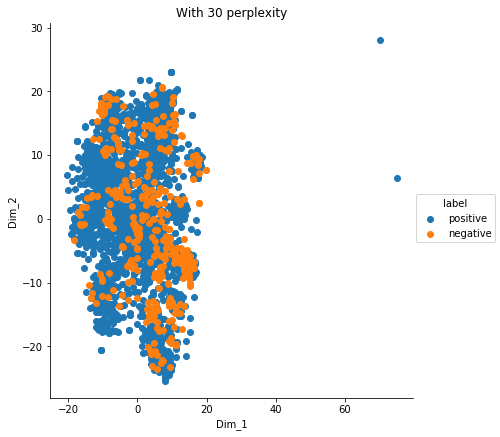

In [20]:
from sklearn.manifold import TSNE

data_2000 = final_counts[0:2000,:]

top_2000 = data_2000.toarray()

labels = final['Score']
labels_2000 = labels[0:2000]

model = TSNE(n_components=2,random_state=0,perplexity=30)

tsne_data = model.fit_transform(top_2000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 30 perplexity")
plt.show()

     Dim_1    Dim_2     label
0 -1.64672 -2.43268  positive
1  3.95686  4.85268  positive
2 -3.84335 -3.50253  positive
3  1.58323 -1.43689  positive
4  -3.8477  -3.5724  positive
(2000, 3)
['positive' 'negative']


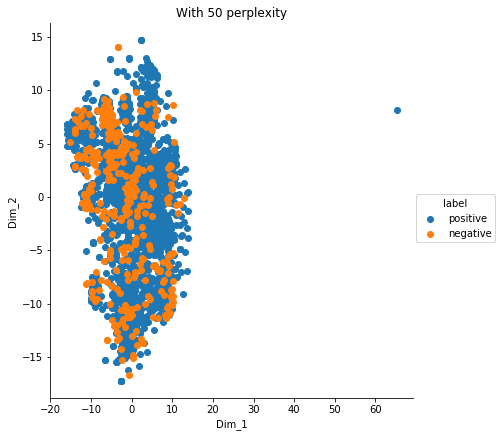

In [21]:
model = TSNE(n_components=2,random_state=0,perplexity=50)
tsne_data = model.fit_transform(top_2000)
tsne_data = np.vstack((tsne_data.T, labels_2000)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 50 perplexity")
plt.show()

     Dim_1     Dim_2     label
0 -2.17272  -3.02385  positive
1  1.88645   1.46954  positive
2 -2.87194  -4.67636  positive
3 -2.24408 -0.712422  positive
4  -2.9355  -4.71388  positive
(2000, 3)
['positive' 'negative']


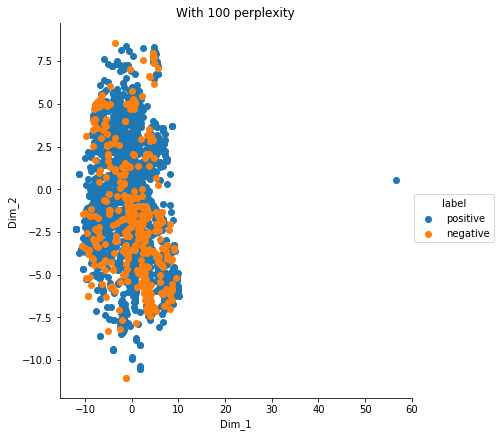

In [23]:
model = TSNE(n_components=2,random_state=0,perplexity=80)
tsne_data = model.fit_transform(top_2000)
tsne_data = np.vstack((tsne_data.T, labels_2000)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 80 perplexity")
plt.show()

In [ ]:
***Observation***

when we take 2000 data points,perplexity(p)=30,50 and 80.

1.Here,we seen that the all of data points are overlap each other but in some are there no overlaps.

2.As we can see clearly perplexity =80 give better visualization btw +ve and -ve points

3.With the increase in perplexity it form dencer (in p=30 less dencer , p=50 more dencer and p=80 max dencer)


# ***An introduction to TF-IDF***

In [ ]:
***An introduction to TF-IDF***

 Term frequency–Inverse document frequency, is a numerical statistic that is intended to reflect how important a 
 word is to a document in a collection or corpus.

 The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of
 documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

 Term Frequency (tf): 
 1.Its gives us the frequency of the word in each document in the corpus.
 2.It is the ratio of number of times the word appears in a document upon the total number of words in that document.
 3.It increases as the number of occurrences of that word within the document increases. Each document has its own tf.

 Inverse Data Frequency (idf):
 1.Used to calculate the weight of rare words across all documents in the corpus.
 2.The words that occur rarely in the corpus have a high IDF score.


In [19]:
#Classification of TF-IDF using Tsne

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#TF-IDF
final_tf_idf = tf_idf_vect.fit_transform(final_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 76693)
the number of unique words including both unigrams and bigrams  76693


In [20]:
features = tf_idf_vect.get_feature_names()
len(features)

76693

In [21]:
print("some sample features(unique words in the corpus)")
features[20000:20010]

some sample features(unique words in the corpus)


['eat gave',
 'eat give',
 'eat given',
 'eat good',
 'eat got',
 'eat grain',
 'eat grape',
 'eat gravi',
 'eat great',
 'eat grub']

In [22]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [23]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)


In [24]:
top_tfidf#display the values

,feature,tfidf
0,version paperback,0.167682
1,incorpor love,0.167682
2,two hand,0.167682
3,keep page,0.167682
4,kind flimsi,0.167682
5,page open,0.167682
6,book watch,0.167682
7,hard cover,0.167682
8,paperback seem,0.167682
9,flimsi take,0.167682


     Dim_1    Dim_2     label
0  18.4865  25.0181  positive
1  19.3418  27.4844  positive
2  18.2128  26.1487  positive
3  19.9199  24.6013  positive
4  18.1996  25.8004  positive
(2000, 3)
['positive' 'negative']


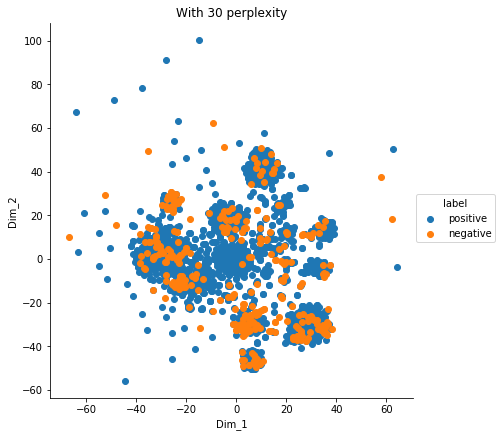

In [28]:
from sklearn.manifold import TSNE

data_2000 = final_tf_idf[0:2000,:]

top_2000 = data_2000.toarray()

labels = final['Score']
labels_2000 = labels[0:2000]

model = TSNE(n_components=2,random_state=0,perplexity=30)

tsne_data = model.fit_transform(top_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 30 perplexity")
plt.show()

     Dim_1    Dim_2     label
0  -7.9325  30.9246  positive
1 -9.07498  32.4053  positive
2 -8.81887  31.1368  positive
3 -6.86922  31.6331  positive
4 -8.50554  30.9799  positive
(2000, 3)
['positive' 'negative']


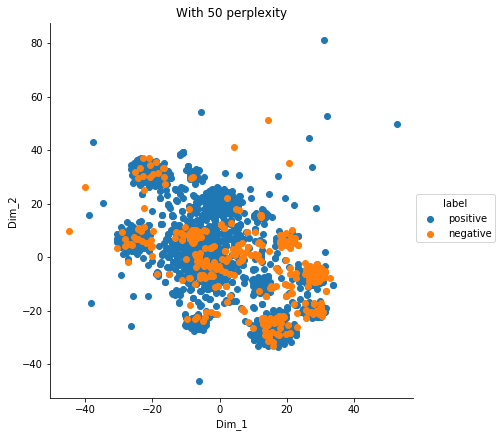

In [29]:
model = TSNE(n_components=2,random_state=0,perplexity=50)

tsne_data = model.fit_transform(top_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 50 perplexity")
plt.show()

     Dim_1    Dim_2     label
0 -1.96796  14.1001  positive
1 -3.53286  15.6696  positive
2 -2.15071  15.1961  positive
3  -2.8423  13.8032  positive
4 -2.05104  14.8877  positive
(2000, 3)
['positive' 'negative']


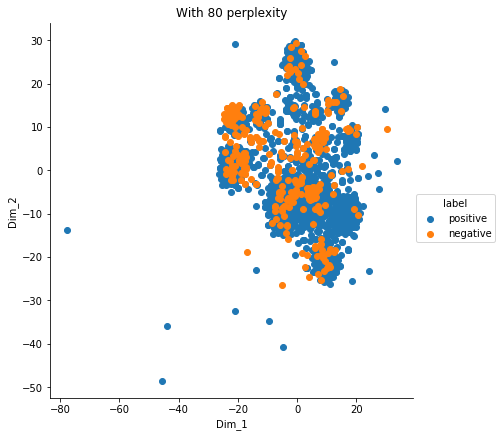

In [30]:
model = TSNE(n_components=2,random_state=0,perplexity=80)

tsne_data = model.fit_transform(top_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 80 perplexity")
plt.show()

In [ ]:
 ***Observation***

when we take 2000 data points,perplexity(p)=30,50 and 80.

1.In p=30, some points are lying far away from each other, +ve and -ve from dencer shape and overlap each other

2.As we can see clearly perplexity =80 give better visualization btw +ve and -ve points, and in bottom no of +ve points are more

3.all -ve point lying in upper portion of graph

4.With the increase in perplexity it form dencer (in p=30 less dencer , p=50 more dencer and p=80 max dencer)



# ***Word2vec***

In [ ]:
***Word2vec***

 Word2vec is an algorithm for constructing vector representations of words, also known as word embeddings. 
 The vector for each word is a semantic description of how that word is used in context, so two words that are used
 similarly in text will get similar vector represenations.Once you map words into vector space, you can then
 use vector math to find words that have similar semantics.



In [1]:
#Using Google NewsWord2Vectors

import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

E:\PYTHON\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
model.wv.similarity('woman', 'man')

E:\PYTHON\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
E:\PYTHON\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7664013

In [ ]:
model.wv.most_similar('tasty') 

#This module is taking so much to execute , with your permission i am skipping this part.

E:\PYTHON\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [53]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
#final_200=final_2000.head(200)
for sent in final_2000['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [54]:
print(final_2000['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [27]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [28]:
words = list(w2v_model.wv.vocab)
print(len(words))

2950


In [29]:
w2v_model.wv.most_similar('love')


[('recommend', 0.9625383615493774),
 ('give', 0.9592059850692749),
 ('buy', 0.9591370820999146),
 ('use', 0.9586638808250427),
 ('think', 0.9552995562553406),
 ('suggest', 0.9536561965942383),
 ('am', 0.9528727531433105),
 ('did', 0.9520022869110107),
 ('try', 0.9509726762771606),
 ('address', 0.9507678747177124)]

In [30]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
count_vect_feat.index('love')
print(count_vect_feat[64055])

sturdi metal


# Classification of avg word2vec using tsne

In [30]:
# average Word2Vec
# compute average word2vec for each review
sent_vectors = [];            # the avg-w2v for each sentence/review is stored in 
                              #this list
for sent in list_of_sent:     # for each review/sentence
    sent_vec = np.zeros(50)   # as word vectors are of zero length
    cnt_words =0;             # num of words with a valid vector in the sentence/review
    for word in sent:         # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


     Dim_1    Dim_2     label
0 -16.6019  -34.909  positive
1 -28.4188 -29.8331  positive
2  30.6477 -34.9776  positive
3 -29.1878   6.8847  positive
4    32.62 -19.7772  positive
(2000, 3)
['positive' 'negative']


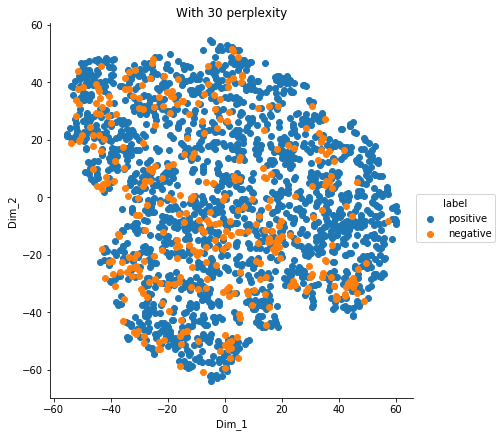

In [37]:
#tsne represention on avg-word2vec
from sklearn.manifold import TSNE

#data_2000 = sent_vectors[0:2000,:]
top_2000 = sent_vectors#data_2000.toarray()

labels = final['Score']
labels_2000 = labels[0:2000]

model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=5000)
tsne_data = model.fit_transform(top_2000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 30 perplexity")
plt.show()

     Dim_1    Dim_2     label
0  15.9693  18.5256  positive
1  22.3966  12.3969  positive
2 -13.0972  24.2813  positive
3  13.1009 -9.65179  positive
4 -16.9753  15.5997  positive
(2000, 3)
['positive' 'negative']


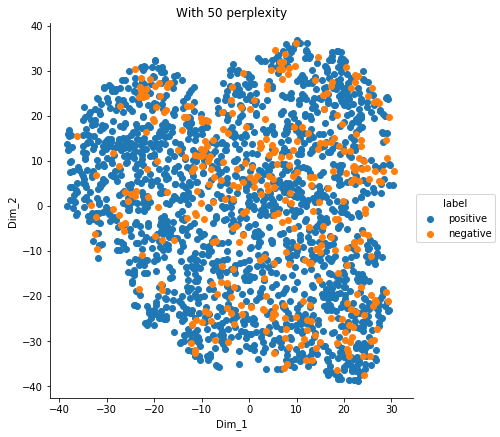

In [38]:
#tsne represention on avg-word2vec
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
tsne_data = model.fit_transform(top_2000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 50 perplexity")
plt.show()

     Dim_1    Dim_2     label
0  3.25893 -14.2138  positive
1  7.60924 -11.6712  positive
2 -15.4788 -12.6805  positive
3  12.7089     4.16  positive
4 -12.1881 -13.0109  positive
(2000, 3)
['positive' 'negative']


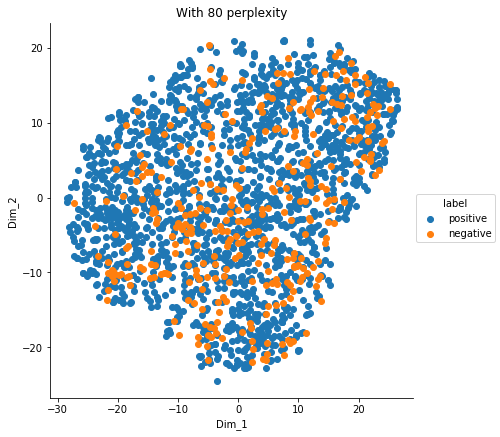

In [39]:
#tsne represention on avg-word2vec
model = TSNE(n_components=2,random_state=0,perplexity=80)
tsne_data = model.fit_transform(top_2000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 80 perplexity")
plt.show()

In [ ]:
 ***Observation***

when we take 2000 data points,
fig 1:(perplexity(p)=30,n_iter=3000),
fig 2: p=50 and n_iter=3000 
fig 3: p=80 and n_iter=default.

Here we seen that all positive and negative data points are overlapping each other 
so we cannot easily distinguish the positive and negative data points but here we 
also seen that a single positive point is shown far from all the points

# TF-IDF Weighted Word2Vec Using TSNE Visulaization

In [88]:
import gensim
i=0
list_of_sent=[]
final_200=final_2000.head(1000)#taking less data points
for sent in final_200['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [89]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this 
                        #list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =1; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            #sent_vec=np.nan_to_num(sent_vec)
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

1000
50


     Dim_1     Dim_2     label
0 -32.2771   10.8941  positive
1 -44.0831   10.8983  positive
2 -43.9017   3.94933  positive
3  42.0109 -0.698956  positive
4   6.4501   -6.4716  positive
(1000, 3)
['positive' 'negative']


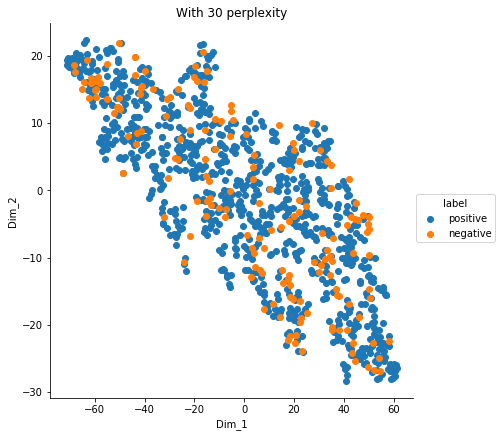

In [98]:
#tsne represention on tf-idf-word2vec
from sklearn.manifold import TSNE

#data_2000 = tfidf_sent_vectors[0:2000,:]
#labels_200=labels_2000.head(200)
top_1000 = tfidf_sent_vectors

labels = final['Score']
labels_2000 = labels[0:1000]

model = TSNE(n_components=2,random_state=0,perplexity=30,)
tsne_data = model.fit_transform(top_1000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 30 perplexity")
plt.show()

      Dim_1    Dim_2     label
0  -8.57187  22.3713  positive
1   -7.4771  30.1256  positive
2  -2.34058  29.2548  positive
3  0.359863 -27.5194  positive
4   4.53321 -3.72371  positive
(1000, 3)
['positive' 'negative']


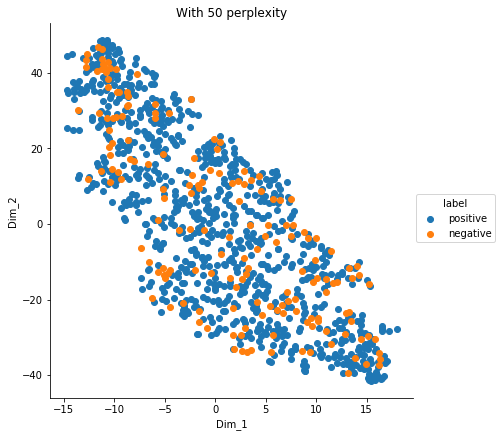

In [99]:
#tsne represention on tf-idf-word2vec
model = TSNE(n_components=2,random_state=0,perplexity=50,)
tsne_data = model.fit_transform(top_1000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 50 perplexity")
plt.show()

      Dim_1    Dim_2     label
0  -12.3796   9.6824  positive
1  -17.0671  10.6644  positive
2  -17.3799  7.34354  positive
3   16.2583 -9.43185  positive
4  0.583541 -3.38612  positive
(1000, 3)
['positive' 'negative']


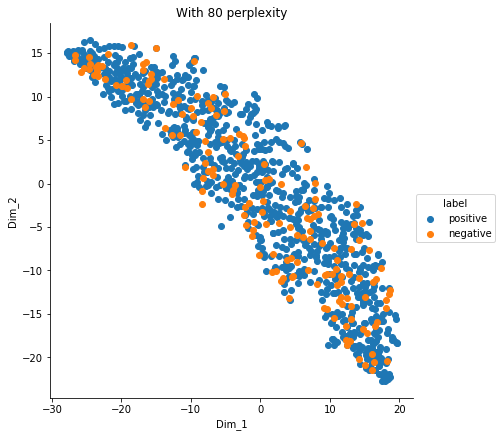

In [100]:
#tsne represention on tf-idf-word2vec
model = TSNE(n_components=2,random_state=0,perplexity=80,)
tsne_data = model.fit_transform(top_1000)

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))

print(tsne_df.head())
print(tsne_df.shape)
print(tsne_df['label'].unique())
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.title("With 80 perplexity")
plt.show()

In [ ]:
Observation=>When we take 1000 data points perpexity=30,50 and 80

1.Here we seen that all positive and negative data points are overlapping each other.

2.so we cannot easily distinguish the positive and negative data points

3.But here we also seen with the increase of perplexity shape is shrinking(p=80)

4.This t-SNE gives the best visualisation and all the points are gathered together.

# ***Conclusion***

In [ ]:
In this assignment we can see that: 

1.Text values into numeric and make the text(reviews) data into numeric data. 

2. So the conclusion driven from this assignment is that we can easily use numeric data to make the plots using tsne in 
this assignment. 

3. We can easily figure out the positive eand negative reviews using the tsne plots. 

--Thanks